Load google drive into the VM:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Preprocess data (calculate delta + labels + save data in data.pkl):

In [0]:
import numpy as np
import pickle


data_directory = 'drive/My Drive/datasets/arabic-digits/'
train_file = 'Train_Arabic_Digit.txt'
test_file = 'Test_Arabic_Digit.txt'
saved_file = 'blocked_data.pkl'

bsize_train = 660
bsize_test = 220
mfcc_len = 13
N = 2
before_after = 9

def derivative(vector):
    dt = np.zeros(mfcc_len)
    s = 2 * np.sum(np.array([k + 1 for k in range(N)]) ** 2)
    for t in range(mfcc_len):
        d = 0
        for j in [k + 1 for k in range(N)]:
            idx1 = t - j if t - j >= 0 else 0
            idx2 = t + j if t + j < mfcc_len else mfcc_len - 1
            d += j * (vector[idx2] - vector[idx1])
        dt[t] = d / s
    return dt

def prepare_data():
    partition = {
        'train_data': [],
        'train_label': [],
        'test_data': [],
        'test_label': [],
        'train_parts': [],
        'test_parts': []
    }
    
    for data_file in [('train', train_file), ('test', test_file)]:
        i = 0
        index = 0
        prev_label = 0
        block = []
#         label_block = []
        with open(data_directory + data_file[1]) as file:
            line = file.readline()
            for line in file:
                if not line.split():
                    i += 1
                    partition[data_file[0] + '_data'].append(block)
                    # partition[data_file[0] + '_label'].append(label_block)
                    block = []
                    # label_block = []
                else:
                    datum = np.array(line.split(), dtype=float)
                    datum = np.concatenate((datum, derivative(datum), derivative(derivative(datum))))
                    # print(datum, datum.shape)
                    label = i // bsize_train if data_file[0] == 'train' else i // bsize_test
                    if label != prev_label:
                      partition[data_file[0] + '_parts'].append(index)
                    block.append(datum)
                    partition[data_file[0] + '_label'].append(label)
                    # label_block.append(label)
                    prev_label = label
                    index += 1
                # print(datum)
                # print(np.array(partition['train_data']).shape)
                # print(line)
        partition[data_file[0] + '_data'].append(block)
#         partition[data_file[0] + '_label'].append(label_block)
        block = []
#         label_block = []
    partition['train_parts'].append(len(partition['train_label']))
    partition['test_parts'].append(len(partition['test_label']))
    pickle.dump(partition, open(data_directory + saved_file, 'wb'))
    return partition

  
def main():
#     prepare_data()
#     prepare_dnn_data()

    partition = pickle.load(open(data_directory + saved_file, 'rb'))
    print(np.array(partition['train_data']).shape, np.array(partition['train_label']).shape, np.array(partition['test_data']).shape, np.array(partition['test_label']).shape)
    print(partition['test_parts'], partition['train_parts'])
#     print(np.array(partition['train_dnn_data']).shape)
#     print(partition['test_label'][partition['test_parts'][7]: partition['test_parts'][8]])


if __name__ == '__main__':
    main()

GMM-HMM Model:

In [0]:
!pip install hmmlearn
import torch
import pickle
import numpy as np
from torch.utils import data
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from hmmlearn import hmm

# constants
bsize_train = 660
bsize_test = 220
mfcc_len = 13
data_directory = 'drive/My Drive/datasets/arabic-digits/'
model_file = 'blocked_model.pkl'
saved_file = 'blocked_data.pkl'


# params
num_states = 6
num_mix = 3

def train_decoder(partition):
  decoder_model = {}
  start = 0
  end = 0
  for label in np.unique(partition['train_label']):
#     if label == 0:
#       start = 0
#       end = partition['train_parts'][label]
#     else:
#       start = partition['train_parts'][label - 1]
#       end = partition['train_parts'][label]
#     print(label)
    start = bsize_train * label
    end = bsize_train * (label + 1)
    
#     print(start, end)
#     print(np.array(partition['train_data'][0]).shape[0])
    lengths = np.array([np.array(partition['train_data'][i]).shape[0] for i in range(start, end, 1)])
    
#     print(lengths, len(lengths), lengths.sum())
    
    train_data = partition['train_data'][start:end]
#     print(train_data)
    train_data = np.vstack(train_data)
    
    
#     print(train_data.shape, train_data[0].shape)
#     lengths = np.array([1 for i in range(end - start)])

#     startprob_prior = np.array([0.5, 0.5, 0, 0, 0, 0],dtype=np.float)

#     decoder_model[label] = hmm.GMMHMM(n_components=num_states, n_mix=num_mix, covariance_type='diag', verbose=True)
    decoder_model[label] = hmm.GaussianHMM(n_components=num_states, covariance_type='diag', verbose=True, n_iter=50)

  #   print(len([1 for i in range(len(partition['train_data']))]), len(partition['train_data']))

  #   n_samples = np.array(partition['train_data']).shape[0]
  #   end = np.cumsum(lengths).astype(np.int32)
  #   print(end.shape)
  #   start = end - lengths
  #   print(start.shape)
  #   print(end[-1])

#     decoder_model[label].fit(np.expand_dims(np.array(partition['train_data'][start:start + 1000]).ravel(), axis=1), lengths)
#     decoder_model[label].fit(np.array(partition['train_data'][start:end]), lengths)
    decoder_model[label].fit(train_data, lengths)


  pickle.dump(decoder_model, open(data_directory + model_file, 'wb'))




  
partition = pickle.load(open(data_directory + saved_file, 'rb'))
partition['train_data'] = np.array(partition['train_data'])
partition['train_label'] = np.array(partition['train_label'])
partition['test_data'] = np.array(partition['test_data'])
partition['test_label'] = np.array(partition['test_label'])
partition['test_parts'] = np.array(partition['test_parts'])
partition['train_parts'] = np.array(partition['train_parts'])




#   train_decoder(partition)

#   lengths = np.array([mfcc_len * 3 for i in range(partition['test_data'].shape[0])])
#   print(lengths)
output = {}
decoder_model = pickle.load(open(data_directory + model_file, 'rb'))
for label in np.unique(partition['test_label']):

  start = bsize_test * label
  end = bsize_test * label + 20

#     print(np.expand_dims(np.array(partition['train_data']).ravel(), axis=1).shape)
#     print(np.reshape(partition['test_data'][partition['test_parts'][label] - 1], (-1, 1)).shape)


#     n_samples = partition['test_data'].shape[0]
#     end = np.cumsum(lengths).astype(np.int32)
#     start = end - lengths
#     print(start.shape, end.shape, end[-1], lengths.shape)

#     lengths = np.array([mfcc_len * 3 for i in range(end - start)])
#     lengths = np.array([1 for i in range(end - start)])

#     output[label] = decoder_model[label].score(np.expand_dims(np.array(partition['train_data']).ravel(), axis=1), lengths)
  lengths = np.array([np.array(partition['test_data'][i]).shape[0] for i in range(start, end, 1)])
  test_data = partition['test_data'][start:end]
  test_data = np.vstack(test_data)

#     output[label] = [decoder_model[i].score(np.reshape(partition['test_data'][bsize_test * label][0], (1, -1))) for i in decoder_model.keys()]

#     output[label] = [decoder_model[i].score(test_data, lengths) for i in decoder_model.keys()]
#     print(np.array(output[label]))
#     print(np.argmax(np.array(output[label])))
  output[label] = np.array([decoder_model[i].predict_proba(np.reshape(partition['test_data'][bsize_test * label][0], (1, -1))) for i in decoder_model.keys()])
#     print(np.argmax(np.array(output[label]), axis=1))
  print(np.argmax(output[label], axis=2))

#   print(len([1 for i in range(len(partition['train_data']))]), len(partition['train_data']))

#   n_samples = np.array(partition['train_data']).shape[0]
#   end = np.cumsum(lengths).astype(np.int32)
#   print(end.shape)
#   start = end - lengths
#   print(start.shape)
#   print(end[-1])

#     decoder_model[label].fit(np.expand_dims(np.array(partition['train_data']).ravel(), axis=1), lengths)
#     decoder_model[label].fit(np.array(partition['train_data'][start:end]))


#   print(decoder_model.transmat_)
#   decoder_out = decoder_model.predict(np.expand_dims(np.array(partition['train_data']).ravel(), axis=1), lengths)
#   print(decoder_model.monitor_, decoder_model.monitor_.converged)
#   print(decoder_out.shape[0] // (3 * mfcc_len))
#   decoder_out = np.reshape(decoder_out, (decoder_out.shape[0] // (3 * mfcc_len), 3 * mfcc_len))
#   unique, counts = np.unique(decoder_out, return_counts=True)
#   print(dict(zip(unique, counts)))

#   train_params = {'batch_size': batch_size,
#             'shuffle': False,
#             'num_workers': 4}



#   test_params = {'batch_size': test_size,
#         'shuffle': False,
#         'num_workers': 4}


#   training_set = Dataset(partition['train_data'], partition['train_label'])
#   training_generator = data.DataLoader(training_set, **train_params)
#   test_set = Dataset(partition['test_data'], partition['test_label'])
#   test_generator = data.DataLoader(test_set, **test_params)

Prepare DNN input data:

In [0]:
model_file = 'blocked_model.pkl'

def prepare_dnn_data():
    decoder_model = pickle.load(open(data_directory + model_file, 'rb'))
    partition = pickle.load(open(data_directory + saved_file, 'rb'))
    partition['train_dnn_data'] = []
    partition['test_dnn_data'] = []
    partition['train_dnn_label'] = []
    partition['test_dnn_label'] = []
    for data_type in ['train', 'test']:
        for i, block in enumerate(partition[data_type + '_data']):
#             print(len(block))
            start = 0
            while start + before_after < len(block):
                d = np.array(block[start: start + before_after])
                partition[data_type + '_dnn_data'].append(d.ravel())
                label = i // bsize_train if data_type == 'train' else i // bsize_test
                output = np.array(decoder_model[label].predict_proba(np.reshape(d[(before_after - 1) // 2], (1, -1))))
#                 print(output)
                one_hot = np.zeros(num_states)
                one_hot[np.argmax(output)] = 1
                partition[data_type + '_dnn_label'].append([one_hot, label])
                start += 1
#             break
#     print(partition['train_dnn_data'][0].shape)
    pickle.dump(partition, open(data_directory + saved_file, 'wb'))
    
prepare_dnn_data()
partition = pickle.load(open(data_directory + saved_file, 'rb'))
print(partition['train_dnn_data'][0], partition['train_dnn_label'][0])

Calculate state probablities:

In [0]:
state_prob_file = 'state_prob.pkl'
def calculate_state_prob():
    decoder_model = pickle.load(open(data_directory + model_file, 'rb'))
    partition = pickle.load(open(data_directory + saved_file, 'rb'))
    res = np.zeros(num_states)
    for data_type in ['train', 'test']:
            for i, block in enumerate(partition[data_type + '_data']):
                for item in block:
                    output = decoder_model[label].predict(np.reshape(item, (1, -1)))
                    res[output] += 1
    s = res.sum()
    for i in range(num_states):
      res[i] /= s
    pickle.dump(res, open(data_directory + state_prob_file, 'wb'))

calculate_state_prob()

probs = pickle.load(open(data_directory + state_prob_file, 'rb'))
print(probs, probs.sum())

DNN Model:

In [0]:
import torch
import numpy as np
import gc
import pickle
from torch.utils import data
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn

num_labels = 10
num_states = 6

class DNN(nn.Module):
    def __init__(self, input_dim=39 * 9, output_dim=num_states * num_labels):
        super(DNN, self).__init__()
        
        self.linear = nn.Sequential(nn.Linear(input_dim, 200), nn.Linear(200, 100), nn.Linear(100, output_dim), nn.LogSoftmax())

    def forward(self, input):
        y_pred = self.linear(input)
        return y_pred

Train DNN:

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[1, 64] Train loss = 4.24978
[1, 128] Train loss = 3.89259
[1, 192] Train loss = 3.73200
[1, 256] Train loss = 3.30360
[1, 320] Train loss = 2.70397
[1, 384] Train loss = 2.51984
[1, 448] Train loss = 2.16041
[1, 512] Train loss = 1.91484
[1, 576] Train loss = 1.09562
[1, 640] Train loss = 1.17350
[1, 704] Train loss = 0.79839
[1, 768] Train loss = 0.74746
[1, 832] Train loss = 0.76477
[1, 896] Train loss = 1.15103
[1, 960] Train loss = 1.37644
[1, 1024] Train loss = 1.12790
[1, 1088] Train loss = 1.13829
[1, 1152] Train loss = 0.82137
[1, 1216] Train loss = 0.83552
[1, 1280] Train loss = 0.57321
[1, 1344] Train loss = 0.74354
[1, 1408] Train loss = 0.58557
[1, 1472] Train loss = 0.72126
[1, 1536] Train loss = 0.54344
[1, 1600] Train loss = 1.15980
[1, 1664] Train loss = 0.70759
[1, 1728] Train loss = 0.90706
[1, 1792] Train loss = 0.61319
[1, 1856] Train loss = 0.68881
[1, 1920] Train loss = 0.66123
[1, 1984] Train loss = 0.77006
[1, 2048] Train loss = 0.70864
[1, 2112] Train loss = 0

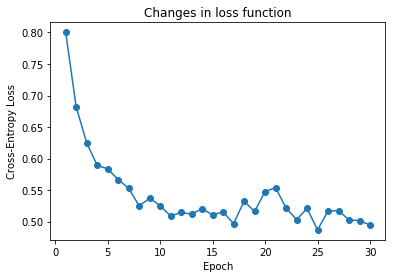

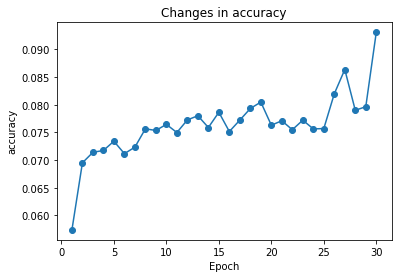

In [54]:
from torch.utils import data
import numpy as np
import torch
import pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt



#params
batch_size = 64
num_epochs = 30

class Dataset(data.Dataset):
    def __init__(self, X, label):
        self.X = np.array(X)
        self.label = np.array(label)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        # self.X = (self.X - self.X.mean()) / self.X.std()
        max_state = np.argmax(self.label[index][0])
        label = max_state + num_states * self.label[index][1]
        return self.X[index], label
      
      
inputs = pickle.load(open(data_directory + saved_file, 'rb'))

test_size = len(partition['test_dnn_label'])
train_size = len(partition['train_dnn_label'])

#     print(len(partition['train_label']), len(partition['validation_label']), len(inputs['data']), len(partition['test_label']))

train_params = {'batch_size': batch_size,
      'shuffle': False,
      'num_workers': 4}

test_params = {'batch_size': test_size,
      'shuffle': False,
      'num_workers': 4}


training_set = Dataset(partition['train_dnn_data'], partition['train_dnn_label'])
training_generator = data.DataLoader(training_set, **train_params)
test_set = Dataset(partition['test_dnn_data'], partition['test_dnn_label'])
test_generator = data.DataLoader(test_set, **test_params)

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     cpu_device = torch.device('cpu')


#     loss_function = torch.nn.MSELoss()
loss_function = F.cross_entropy
model = DNN().double()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.5)

acc = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)
train_loss = np.zeros(num_epochs)

for epoch in range(num_epochs):
    i = 0
    epoch_loss = []
    total_test_loss = 0.0
    model.zero_grad()
    for x, y in training_generator:
        x = x.double()
        y = y.long()
#             x, y = x.to(device), y.to(device)
        y_pred = model(x)
#             print(y_pred.size(), y.size())
        loss = loss_function(y_pred, y)
        epoch_loss.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()

        print('[%d, %d] Train loss = %.5f' %
            (epoch + 1, i + batch_size, loss.item()))
        i += batch_size

    # scheduler.step()


    train_loss[epoch] = np.array(epoch_loss).mean()
    print('[%d] Train loss = %.5f' %
            (epoch + 1, np.array(epoch_loss).mean()))

    for x, y in test_generator:
        x = x.double()
        y = y.long()
#             x, y = x.to(device), y.to(device)
        y_pred = model(x)
        acc[epoch] = int((torch.argmax(y_pred, dim=1) == y).sum())

    acc[epoch] = acc[epoch] / (len(test_generator) * test_size)
    print('[%d] Test acc = %.5f' % (epoch + 1, acc[epoch]))

plt.plot([i + 1 for i in range(num_epochs)], [t for t in train_loss], marker='o')
plt.title('Changes in loss function')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
#plt.figure()
plt.savefig('loss.jpg')
plt.figure()
# plt.show()
plt.plot([i + 1 for i in range(num_epochs)], [a for a in acc], marker='o')
plt.title('Changes in accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.savefig('acc.jpg')
# plt.show()
    

